# Neural Networks

## Hand-in: Study CIFAR classification with CNNs and data augmentation in tensorflow or pytorch in-depth

The goal of this exercise is to explore the power of systematic data augmentation to train you in more systematically analysing your ML approach.

We will look again into the more advanced task for image classification with CNNs: classifying on CIFAR10. But now, we want to include the monitoring and analysis options that are sensible to apply. If you already looked into this yesterday, then: good job! You made today's tasks much easier. Yet

For the hand-in, go through the following tasks and answer the following questions.

Tasks:
1. Take your HAND-IN_cnn from yesterday's exercise as a starting point for this hand-in (copy+paste all your working code for data loading, model building + training, and analysis).
2. Add some systematic data augmentation as a pre-processing step! **See under 2. Preprocessing: Data Augmentation**
3. Add k-fold cross-validation (e.g. k=5)! **See under 5. Train the model**
4. Add particular training monitor plots: plot loss and accuracy over the training steps and reproduce some of yesterday's as well as add more hyperparameter exploration. **See under 7. Analyse some training progress and 8. Analyse the mode**
5. Try out some regularization: e.g. with adding a Normalization layer or Dropout layer [1], or (manually or trough the optimizer) add L1 or L2 regularization to your model [2]. **See under 5. Build the model and 6. Train the model**
6. Add particular analysis steps: show a confusion matrix over all classes, plot a histogram of predictions for the classes, and plot some of the correctly vs. incorrectly classified images. **See under 8. Analyse the model**

Questions:
1. Did data augmentation improve your model? Which augmentation methods were most useful (thus, you might systematically turn individual ones on/off, but DON'T put too much time into that). **Yes. See under Question 1**

2. Did you observe that cross-validation helps for better results? **Yes. See under Question 2**
3. Did you observe that a particular regularization helps for better results? **Yes. See under Question 3**
4. Recapitulate: Are there classes that are difficult to classify correctly? Is this still the case with augmentation?b **See under Question 4-5**
5. Can you identify particular images that fail to classify consistently? Speculate: why? **See under Question 4-5**

[1] https://pytorch.org/docs/stable/nn.html

[2] Good starting point: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md

## 0. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch import optim
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import seaborn as sns

import os
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
from sklearn.model_selection import KFold

## 1. Load CIFAR-10 from tensorflow or pytorch

In [36]:
# transform = transforms.Compose(
 #  [transforms.ToTensor()])

trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
# trainvalloader = torch.utils.data.DataLoader(trainvalset, batch_size=batch_size, shuffle=True, num_workers=2) # will be created including augmenation and preprocessing steps later

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2) # will be created including augmenation and preprocessing steps later

Files already downloaded and verified
Files already downloaded and verified


## 2. Preprocessing: Data Augmentation
Add some data augmentation steps here!


In [35]:
# Define the transformations
size = (32, 32)  # Define size of images

# Transformation for test and validation steps
val_test_transform = transforms.Compose([transforms.Resize(size), # same steps exlcuding Augmenation (flipping & rotation) as test set should be unprocessed
                                         transforms.ToTensor()])

# Transformation for trainin set: Different augmentation techniques will be tested to evaluate the performance
def train_transform_funct(intensity):
  if intensity == "no":
    train_transform = transforms.Compose([
                    transforms.Resize(size), # resize to previously defined size
                    transforms.ToTensor()])

  elif intensity == "light":
    train_transform = transforms.Compose([
                    transforms.Resize(size), # resize to previously defined size
                    transforms.RandomHorizontalFlip(), # randomly horizontal flip images
                    transforms.ToTensor()])

  elif intensity == "light2":
    train_transform = transforms.Compose([
                    transforms.Resize(size), # resize to previously defined size
                    transforms.RandomRotation(10), # randomly rotate images
                    transforms.ToTensor()])

  elif intensity == "medium":
    train_transform = transforms.Compose([
                    transforms.Resize(size), # resize to previously defined size
                    transforms.RandomHorizontalFlip(), # randomly horizontal flip images
                    transforms.RandomRotation(10), # randomly rotate images
                    transforms.ToTensor()])

  elif intensity == "high":
    train_transform = transforms.Compose([
                    transforms.Resize(size), # resize to previously defined size
                    transforms.RandomHorizontalFlip(), # randomly horizontal flip images
                    transforms.RandomVerticalFlip(), # randomly vertical flip images
                    transforms.RandomRotation(10), # randomly rotate images
                    transforms.ColorJitter(brightness=0.8, contrast=0.2, saturation=0.8, hue=0.2), # randomly changes brightness, contrast, saturation & hue
                    transforms.GaussianBlur(kernel_size=size[0] // 20 * 2 + 1, sigma=(0.1, 2.0)), # Apply a random Gaussian blur to the images to simulate a slightly out-of-focus appearance.
                    transforms.ToTensor()])
  else:
    return "Error"

  return train_transform

# NOTE: Data Transformation steps will be applied after the splitting of the validation and training set

## 3. Data Splitting
Here we would do some advanced splitting like n-fold cross-validation! The code stub just gives you a head start...

#### Without n-fold cross-validation

In [37]:
# Define the sizes for the training and validation sets
size_trainset = len(trainvalset)
split_trainval = [.8, .2]

# Split the dataset into training and validation sets
g = torch.Generator()
g.manual_seed(1)  # use different random seeds here! e.g. numbers 0 to k

trainset, valset = torch.utils.data.random_split(trainvalset, [int(size_trainset*split_trainval[0]), int(size_trainset*split_trainval[1])])

In [39]:
# Transform the data without augmentation
train_transform1 = train_transform_funct(intensity = "light") # due to result of question 1 (see below)

train_data = [(train_transform1(x), y) for x, y in trainset]
val_data = [(val_test_transform(x), y) for x, y in valset]

test_data = [(val_test_transform(x), y) for x, y in testset]

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [40]:
# Check if splitting was succesful
print("Number of Images in Training & validation Dataset:", len(trainvalset))
print("Number of Images in Training Dataset:", len(trainset))
print("Number of Images in Validation Dataset:", len(valset))
print("Number of Images in Test Dataset:", len(testset))

Number of Images in Training & validation Dataset: 50000
Number of Images in Training Dataset: 40000
Number of Images in Validation Dataset: 10000
Number of Images in Test Dataset: 10000


#### With n-fold cross validation

In [7]:
# Test set is the same as for n-fold cross validation
# Training and validation will be splitted in the training function
# Augmentation steps will be applied after splitting in the function

## 4. Show some data characteristics

This shows the first 64 images in the training set


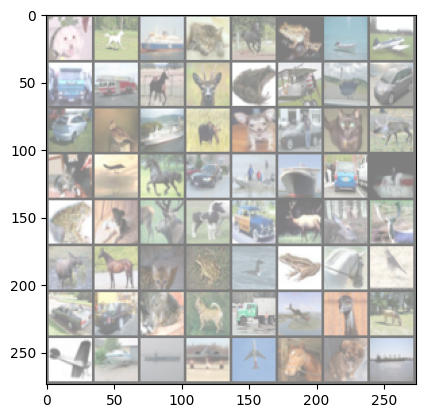

In [8]:
NO_images = batch_size  # The number of images to display

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images = []
imagebatch, label = next(dataiter)

for i in range(NO_images):
    # draw some random images from the training set according to the dataloader
    image = torch.squeeze(imagebatch[i], 0)
    images.append(image)

images = torch.stack(images).cpu()

# print images
print(f"This shows the first {NO_images} images in the training set")
imshow(torchvision.utils.make_grid(images))

## 5. Build the model
Try out regularization as layers or optimiser characteristic.

In [9]:
def LeNet_model():
    """
    Creates a LeNet-5 model architecture.
    Returns:
        nn.Sequential: LeNet model consisting of convolutional and fully connected layers for a 32x32 pixel image.
    """
    return nn.Sequential(
        nn.Conv2d(3, 6, 5, 1),  # Changed due to input size (32x32 instead of 28x28)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)           # Fully connected layer with 10 output classes (CIFAR-10)
    )


In [49]:
def LeNet_model_adjusted(dropout_rate):
    """
    Creates a LeNet-5 model architecture.
    Input:
        dropout_rate: Rate of dropout for dropout layers.
    Returns:
        nn.Sequential: LeNet model consisting of convolutional and fully connected layers for a 32x32 pixel image.
    """
    return nn.Sequential(
        nn.Conv2d(3, 6, 5, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        # nn.Dropout2d(p=dropout_rate), # Add dropout with dropout_rate probability -> was tested but did not get good results
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(p=dropout_rate), # Add dropout with dropout_rate probability
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )


## 6. Train the model
In the following, only the code for the function is given. The actual training is at the bottom to have a better overview of the exercises and results (to compare them directly depending on the task).

In [11]:
# Create function that trains the model with different hyperparameters as inputs, the model and loaders
# Same as in notebook from session 5 (only slight adjustments, e.g. input name_saving_model to get different models saved and not overwritten)

def train(model, name_saving_model, loaders, learning_rate=0.01, num_epochs=50, early_stopping_patience=5):
    loss_f = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    min_valid_loss = np.inf
    best_val_accuracy = 0
    best_epoch = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    if torch.cuda.is_available():
        model.cuda()

    # implement early stopping
    early_stopping_counter = 0
    early_stopping_threshold = 1e-4  # Minimum change in validation loss to consider as improvement

    for epoch in range(num_epochs):
        # Train the model
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        # This line tells the NN that it's in the training mode
        model.train()
        for i, (images, labels) in enumerate(loaders['train']):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = loss_f(output, labels)
            epoch_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

        accuracy_train = correct_train / total_train
        train_accuracies.append(accuracy_train)

        # Validate the model
        epoch_val_loss = 0
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for images_v, labels_v in loaders['validation']:
                if torch.cuda.is_available():
                    images_v, labels_v = images_v.cuda(), labels_v.cuda()
                output = model(images_v)
                loss_v = loss_f(output, labels_v)
                epoch_val_loss += loss_v.item()

                _, predicted = torch.max(output.data, 1)
                total_val += labels_v.size(0)
                correct_val += (predicted == labels_v).sum().item()

        accuracy_val = correct_val / total_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
        print(f'Training Accuracy: {accuracy_train}')
        print(f'Validation Accuracy: {accuracy_val}')
        print('-------------------')

        if min_valid_loss - epoch_val_loss > early_stopping_threshold:
            early_stopping_counter = 0
            min_valid_loss = epoch_val_loss
            # Saving State Dict (best model)
            best_model_filename = f'best_model_fold_{name_saving_model}.pth'
            torch.save(model.state_dict(), best_model_filename) # Save best model

        else:
            early_stopping_counter += 1

        if accuracy_val > best_val_accuracy:
            best_val_accuracy = accuracy_val
            best_epoch = epoch + 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered. Stopping training.")
            break

        train_losses.append(epoch_train_loss / len(loaders["train"]))
        val_losses.append(epoch_val_loss / len(loaders["validation"]))

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_accuracy, best_epoch, best_model_filename

Additional Functions for k-fold cross validation

In [12]:
# function to reset the weights of the model: at each cross-validation fold the model starts again and doesnt take learning from previous fold
def reset_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    m.reset_parameters()

In [13]:
# Create function that trains the model with different hyperparameters as inputs, the model and loaders

def train_crossval(model, dataset_train, train_transform_funct, intensity, val_transform, k=5, learning_rate=0.01, num_epochs=50, batch_size = 64, early_stopping_patience=5, L2_reg_rate = 0.0001, name_saving_model = "NA"):

    loss_f = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = L2_reg_rate) # Add weight decay for L2 regularization


    # Implement k-fold cross validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store results from all folds
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    best_fold_accuracies = []

    # List to store models that were trained
    best_model_filename_list = []
    best_model_metrices = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset_train)))):

      train_subset = torch.utils.data.Subset(dataset_train, train_idx)
      train_transform_pipe = train_transform_funct(intensity = intensity)

      train_data = [(train_transform_pipe(x), y) for x, y in train_subset]

      val_subset = torch.utils.data.Subset(dataset_train, val_idx)

      val_data = [(val_transform(x), y) for x, y in val_subset]


      loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
      loader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)


      model.apply(reset_weights)


      train_losses, val_losses, train_accuracies, val_accuracies, best_val_accuracy, best_epoch, best_model_filename = train(model = model, name_saving_model = name_saving_model, loaders = {'train':loader_train, 'validation': loader_val}, learning_rate=learning_rate, num_epochs=num_epochs, early_stopping_patience=early_stopping_patience)

      print("Best Validation Accuracy:", best_val_accuracy, "Best epoch:",best_epoch) # print the best accurac and validation accuracy of this fold

      # Lists to store results from each folds
      all_train_losses.append(train_losses)
      all_val_losses.append(val_losses)
      all_train_accuracies.append(train_accuracies)
      all_val_accuracies.append(val_accuracies)
      best_fold_accuracies.append(best_val_accuracy)

      best_model_filename_list.append(best_model_filename)
      best_model_metrices.append([ train_losses, val_losses, train_accuracies, val_accuracies, best_val_accuracy])


    # Calculate evluation matrices mean and standard deviation of accuracies and mean of losses
    mean_best_fold_accuracy = np.mean(best_fold_accuracies)
    std_best_fold_accuracy = np.std(best_fold_accuracies)

    # Getting best model
    # index of model with the highest vlaidation accuracy
    best_fold_index = best_fold_accuracies.index(max(best_fold_accuracies))
    best_model_filename = best_model_filename_list[best_fold_index]
    best_model_metrices = best_model_metrices[best_fold_index]


    return mean_best_fold_accuracy, std_best_fold_accuracy, best_model_metrices, best_model_filename

## 7. Analyse some training progress
Add plots for loss/accuracy here!
In the following, only the code for the function is given. The actual training is at the bottom to have a better overview of the exercises and results (to compare them directly depending on the task).

In [14]:
# Create a function for plotting the training curves
def plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training and validation loss and accuracy curves.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
    """
    plt.figure(figsize=(16, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 8. Analyse the model
Add: confusion matrix, histogram over classes, plot individual images.
Bonus: use the TSNE sample code for CIFAR10 as well. Does this help your insight?  In the following, only the code for the function is given. The actual training is at the bottom to have a better overview of the exercises and results (to compare them directly depending on the task).

### Test Accuracy & Confusion Matrix

In [15]:
# Define function with model and test data from loader as input, returns accuracy of test data
def evaluate_confusion_matrix(model, test_loader, label_nr):
    """
    Evaluate the accuracy of a trained model on test data and display the confusion matrix.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        label_nr (int): Number of labels/classes in the dataset.

    Returns:
        float: Test accuracy.
    """
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    all_predicted = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            if torch.cuda.is_available():
                test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
            output = model(test_imgs)
            _, predicted = torch.max(output.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    accuracy = correct / total
    print("Test accuracy: {:.3f}".format(accuracy))

    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(label_nr), yticklabels=range(label_nr))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

### Further Analysis

In [124]:
def plot_correct_vs_incorrect_images(model, test_loader, num_samples=1, image_size=(10, 6)):
    """
    Plot some of the correctly vs. incorrectly classified images.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        num_samples (int, optional): Number of sample images to plot for each category. Defaults to 5.
        image_size (tuple, optional): Size of the plot (width, height). Defaults to (10, 6).

    Returns:
        None
    """
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    correct_samples = {label: [] for label in label_names}
    incorrect_samples = {label: [] for label in label_names}
    incorrect_labels = []

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            if torch.cuda.is_available():
                test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
            output = model(test_imgs)
            _, predicted = torch.max(output.data, 1)

            for i in range(len(test_labels)):
                label = label_names[test_labels[i]]
                if predicted[i] == test_labels[i]:
                    if len(correct_samples[label]) < num_samples:
                        correct_samples[label].append(test_imgs[i].cpu())
                else:
                    if len(incorrect_samples[label]) < num_samples:
                        incorrect_samples[label].append(test_imgs[i].cpu())
                        incorrect_labels.append(label_names[test_labels[i]])

    plt.figure(figsize=image_size)
    for idx, label in enumerate(label_names):
        plt.subplot(len(label_names), 2, idx*2+1)
        plt.imshow(torchvision.utils.make_grid(correct_samples[label], nrow=num_samples).permute(1, 2, 0))
        plt.title('Correctly Classified - {}'.format(label))
        plt.axis('off')

        plt.subplot(len(label_names), 2, idx*2+2)
        plt.imshow(torchvision.utils.make_grid(incorrect_samples[label], nrow=num_samples).permute(1, 2, 0))
        title = 'Incorrectly Classified\nPred: {} | True: {}'.format(incorrect_labels[idx], label)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [118]:
def plot_predictions_histogram(model, test_loader):
    """
    Plot a histogram of predictions for the classes.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        label_names (list): List of label names.

    Returns:
        None
    """
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    all_predicted = []

    with torch.no_grad():
        for test_imgs, _ in test_loader:
            if torch.cuda.is_available():
                test_imgs = test_imgs.cuda()
            output = model(test_imgs)
            _, predicted = torch.max(output.data, 1)
            all_predicted.extend(predicted.cpu().numpy())

    plt.figure(figsize=(10, 6))
    plt.hist(all_predicted, bins=len(label_names), alpha=0.7, color='blue', edgecolor='black')
    plt.xticks(range(len(label_names)), label_names, rotation=45)
    plt.xlabel('Predicted Class')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Classes')
    plt.show()


## Question 1: Systematically experimenting with data augmentation
Did data augmentation improve your model? Which augmentation methods were most useful (thus, you might systematically turn individual ones on/off, but DON'T put too much time into that).

### FINDINGS

Accuracy & Standard deviation
* No Data Augmentation: It achieved a mean validation accuracy of 0.614, with a relatively low standard deviation of 0.0088 between different folds. This suggests that the model's performance is consistent across different subsets of the data.
* **Random Horizontal Flip**: It resulted in a higher **mean best validation accuracy of 0.62058**, with a moderate standard deviation of 0.00664. This augmentation likely helped the model generalize better by considering introducing slight changes in the data to create new versions of the images.
* Random Rotation Augmentations: Text fett markieren The model achieved a mean best validation accuracy of 0.60848, with a relatively low standard deviation of 0.00508.
* Random Horizontal Flip & Random Rotation: Combining both random horizontal flip and random rotation augmentations led to a mean best validation accuracy of 0.6039, but with a higher standard deviation of 0.01425.
* **many different augmentations**: It results in the lowest mean validation accuracy (0.486) but a **small standard deviation (0.0034)**.


Learning Curves
* Learning curves overall look similar. However, the **gap between validation and training error appears to slightly decrease with more augmentaiton methods**. This makes sense as data augmentation increases the variety / noise in the training data and thus the model might be able to generalize better / learn more relevant patterns.

Overall Result
* Results are not clear if and which augmentaiton techniques are the best. However, it can be included that to many augmentation techniques at once are not going to perform well as the mean accuracy is very low. It could lead to low performance due to an increased risk of introducing conflicting or excessive variations, making it harder for the model to learn meaningful features and patterns from the augmented data.
* While it is a tradeoff between validation accuracy and standard deviation. Random Horizontal FLip has the highest mean validaiton accuracy. Many augmentations lead to the best sd.
* In conclusion, it is decided to include **random horizontal flip** as technique as a high accuracy is the main objective and the standard deviation is still moderate.

### Training the Models

**Without Augmentation**

In [16]:
# Creating model
model1 = LeNet_model()

# Define hyperparameters (fixed for the following test with augmentation)
learning_rate= 0.001
num_epochs= 20
early_stopping_patience=5
val_transform = val_test_transform
train_transform_funct = train_transform_funct
batch_size = 64
L2_reg_rate = 0
k = 5

intensity = "no"
name_saving_model = "model1"

mean_accuracy_model1, std_accuracy_model1, best_model_metrices_model1,best_model_filename_model1  =  train_crossval(model1, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.8286638711929322
Validation Loss: 1.6506749907876277
Training Accuracy: 0.3193
Validation Accuracy: 0.3965
-------------------
Epoch 2
Training Loss: 1.5419040353775024
Validation Loss: 1.4550201171522688
Training Accuracy: 0.434625
Validation Accuracy: 0.4673
-------------------
Epoch 3
Training Loss: 1.4330987419128418
Validation Loss: 1.386711236018284
Training Accuracy: 0.47535
Validation Accuracy: 0.4898
-------------------
Epoch 4
Training Loss: 1.353412896347046
Validation Loss: 1.3287459619485649
Training Accuracy: 0.510275
Validation Accuracy: 0.5196
-------------------
Epoch 5
Training Loss: 1.2856680782318115
Validation Loss: 1.3353528611978907
Training Accuracy: 0.5367
Validation Accuracy: 0.5185
-------------------
Epoch 6
Training Loss: 1.2345798253059388
Validation Loss: 1.2657059905635324
Training Accuracy: 0.555525
Validation Accuracy: 0.5461
-------------------
Epoch 7
Training Loss: 1.186107778453827
Validation Loss: 1.2236018598459328
Traini

**With Random Horizontal Flip**

In [17]:
# Creating model
model2 = LeNet_model()

# Same hyperparameters as before
# New hyperparameters
intensity = "light"
name_saving_model = "model2"

mean_accuracy_model2, std_accuracy_model2, best_model_metrices_model2,best_model_filename_model2  =  train_crossval(model2, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.831651058769226
Validation Loss: 1.6065423898636155
Training Accuracy: 0.3202
Validation Accuracy: 0.4059
-------------------
Epoch 2
Training Loss: 1.5315477630615235
Validation Loss: 1.4616015693943971
Training Accuracy: 0.4407
Validation Accuracy: 0.4686
-------------------
Epoch 3
Training Loss: 1.4031640953063964
Validation Loss: 1.394336584267343
Training Accuracy: 0.492025
Validation Accuracy: 0.4958
-------------------
Epoch 4
Training Loss: 1.3252783397674561
Validation Loss: 1.3151072666143915
Training Accuracy: 0.52205
Validation Accuracy: 0.5225
-------------------
Epoch 5
Training Loss: 1.2649496205329895
Validation Loss: 1.271605931649542
Training Accuracy: 0.544175
Validation Accuracy: 0.5448
-------------------
Epoch 6
Training Loss: 1.2132916778564453
Validation Loss: 1.2661226080481414
Training Accuracy: 0.564675
Validation Accuracy: 0.5479
-------------------
Epoch 7
Training Loss: 1.1690598288536072
Validation Loss: 1.2636174825346393
Traini

**With Random Rotation**

In [18]:
# Creating model
model3= LeNet_model()

# Same hyperparameters as before
# New hyperparameters
intensity = "light2"
name_saving_model = "model3"

mean_accuracy_model3, std_accuracy_model3, best_model_metrices_model3, best_model_filename_model3  =  train_crossval(model3, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.8680341787338257
Validation Loss: 1.6665987300265366
Training Accuracy: 0.30255
Validation Accuracy: 0.3907
-------------------
Epoch 2
Training Loss: 1.593004602432251
Validation Loss: 1.4929535973603558
Training Accuracy: 0.421725
Validation Accuracy: 0.4567
-------------------
Epoch 3
Training Loss: 1.4490368629455566
Validation Loss: 1.4883542319012295
Training Accuracy: 0.4761
Validation Accuracy: 0.4753
-------------------
Epoch 4
Training Loss: 1.371375472164154
Validation Loss: 1.3284206732063537
Training Accuracy: 0.5086
Validation Accuracy: 0.5276
-------------------
Epoch 5
Training Loss: 1.312255385875702
Validation Loss: 1.3266232567987624
Training Accuracy: 0.527725
Validation Accuracy: 0.5285
-------------------
Epoch 6
Training Loss: 1.2625007363319396
Validation Loss: 1.2604717999506907
Training Accuracy: 0.54915
Validation Accuracy: 0.553
-------------------
Epoch 7
Training Loss: 1.226137010383606
Validation Loss: 1.2211882278418085
Training 

**With Random Horizontal Flip & RandomRotation**

In [19]:
# Creating model
model4= LeNet_model()

# Same hyperparameters as before
# New hyperparameters
intensity = "medium"
name_saving_model = "model4"

mean_accuracy_model4, std_accuracy_model4, best_model_metrices_model4, best_model_filename_model4  =  train_crossval(model4, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.8224679704666138
Validation Loss: 1.6148197886290823
Training Accuracy: 0.321375
Validation Accuracy: 0.4096
-------------------
Epoch 2
Training Loss: 1.5304324396133422
Validation Loss: 1.4364534198858177
Training Accuracy: 0.439975
Validation Accuracy: 0.4798
-------------------
Epoch 3
Training Loss: 1.4156345317840575
Validation Loss: 1.408474115809058
Training Accuracy: 0.485925
Validation Accuracy: 0.5
-------------------
Epoch 4
Training Loss: 1.3432373600006104
Validation Loss: 1.3673102301397142
Training Accuracy: 0.515675
Validation Accuracy: 0.5066
-------------------
Epoch 5
Training Loss: 1.2889778447151183
Validation Loss: 1.265363944563896
Training Accuracy: 0.53765
Validation Accuracy: 0.5507
-------------------
Epoch 6
Training Loss: 1.2532141885757446
Validation Loss: 1.2478487127146143
Training Accuracy: 0.550825
Validation Accuracy: 0.5573
-------------------
Epoch 7
Training Loss: 1.2127175302505493
Validation Loss: 1.2298414756538003
Trai

**With Many different Augmentation Methods**

In [23]:
# Creating model
model5= LeNet_model()

# Same hyperparameters as before
# New hyperparameters
intensity = "high"
name_saving_model = "model5"

mean_accuracy_model5, std_accuracy_model5, best_model_metrices_model5, best_model_filename_model5  =  train_crossval(model5, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 2.0724732149124145
Validation Loss: 1.841246869913332
Training Accuracy: 0.22825
Validation Accuracy: 0.3265
-------------------
Epoch 2
Training Loss: 1.8395705379486085
Validation Loss: 1.717164795869475
Training Accuracy: 0.326825
Validation Accuracy: 0.3793
-------------------
Epoch 3
Training Loss: 1.7613011220932007
Validation Loss: 1.7004838528906463
Training Accuracy: 0.357075
Validation Accuracy: 0.3906
-------------------
Epoch 4
Training Loss: 1.712318553352356
Validation Loss: 1.6199110769162512
Training Accuracy: 0.377025
Validation Accuracy: 0.4039
-------------------
Epoch 5
Training Loss: 1.66899042263031
Validation Loss: 1.5970329441082705
Training Accuracy: 0.39465
Validation Accuracy: 0.4238
-------------------
Epoch 6
Training Loss: 1.635022665977478
Validation Loss: 1.5948496533047622
Training Accuracy: 0.407525
Validation Accuracy: 0.4237
-------------------
Epoch 7
Training Loss: 1.6044078084945679
Validation Loss: 1.6214023623496863
Traini

### Summary of Mean Fold Validation Accuracy & Standard Deviation

In [25]:
print("Mean of the best found validation accuracy...")
print("with no data augmentation:", mean_accuracy_model1, "Standard deviation between folds:", std_accuracy_model1 )
print("with Random Horizontal Flip:", mean_accuracy_model2, "Standard deviation between folds:", std_accuracy_model2)
print("with Random Rotation augmentations:", mean_accuracy_model3, "Standard deviation between folds:", std_accuracy_model3 )
print("with Random Horizontal Flip & RandomRotation::", mean_accuracy_model4, "Standard deviation between folds:", std_accuracy_model4 )
print("with many different augmentations:", mean_accuracy_model5, "Standard deviation between folds:", std_accuracy_model5 )

Mean of the best found validation accuracy...
with no data augmentation: 0.614 Standard deviation between folds: 0.008770176737101702
with Random Horizontal Flip: 0.62058 Standard deviation between folds: 0.006637589924061307
with Random Rotation augmentations: 0.6084799999999999 Standard deviation between folds: 0.005080314950866714
with Random Horizontal Flip & RandomRotation:: 0.6039 Standard deviation between folds: 0.01424836832763665
with many different augmentations: 0.48597999999999997 Standard deviation between folds: 0.003435927822291977


### Analysis of Training Progress

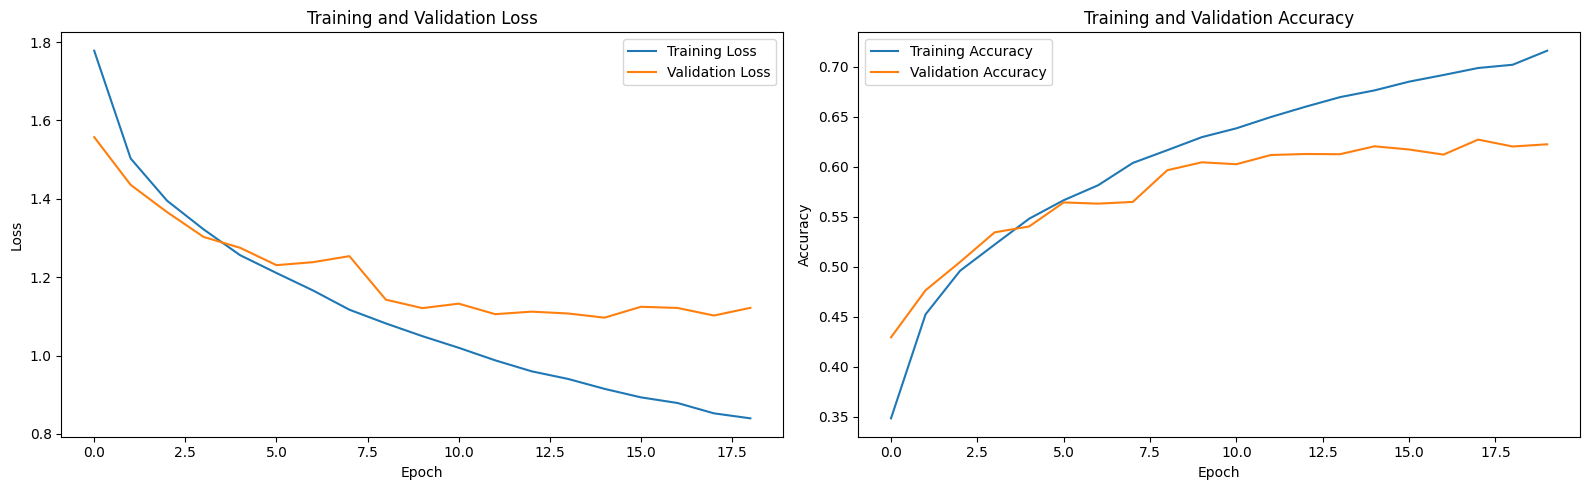

In [27]:
# Ploting Learning Curves
plot_training_curve(best_model_metrices_model1[0], best_model_metrices_model1[1], best_model_metrices_model1[2], best_model_metrices_model1[3])

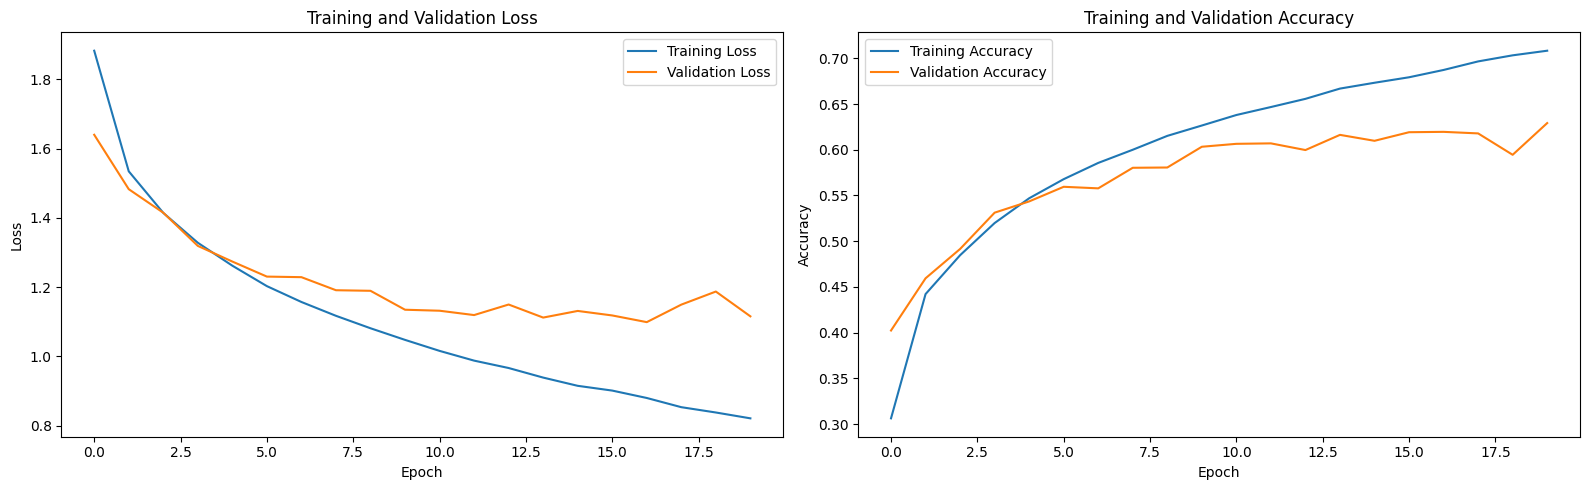

In [28]:
plot_training_curve(best_model_metrices_model2[0], best_model_metrices_model2[1], best_model_metrices_model2[2], best_model_metrices_model2[3])

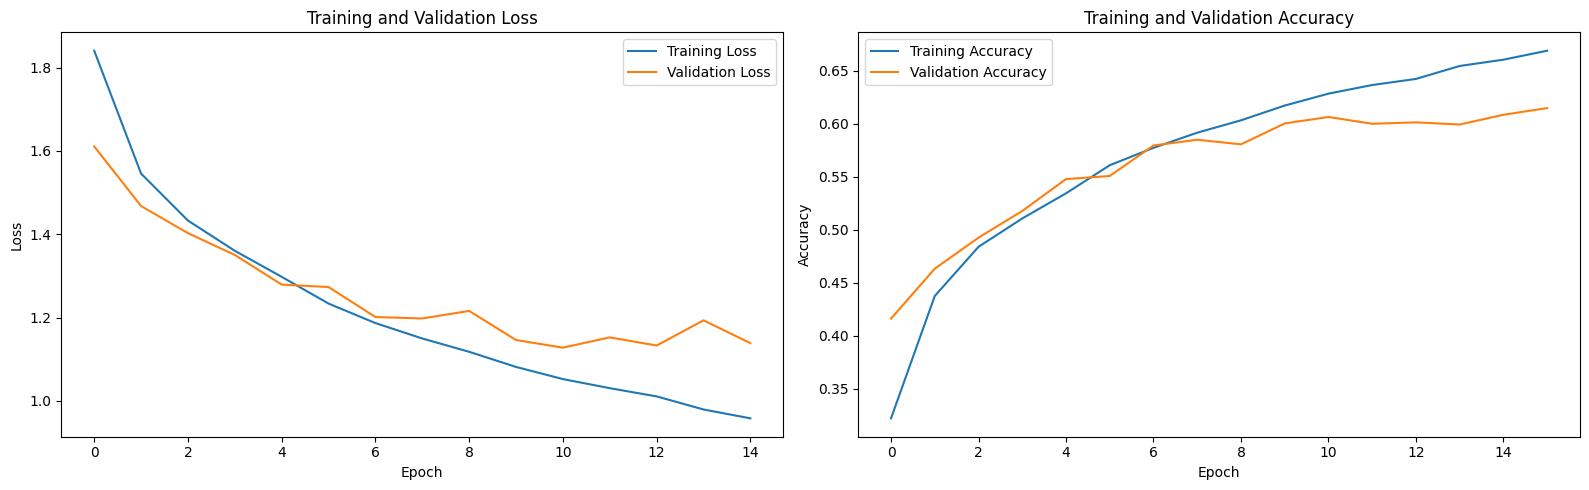

In [29]:
plot_training_curve(best_model_metrices_model3[0], best_model_metrices_model3[1], best_model_metrices_model3[2], best_model_metrices_model3[3])

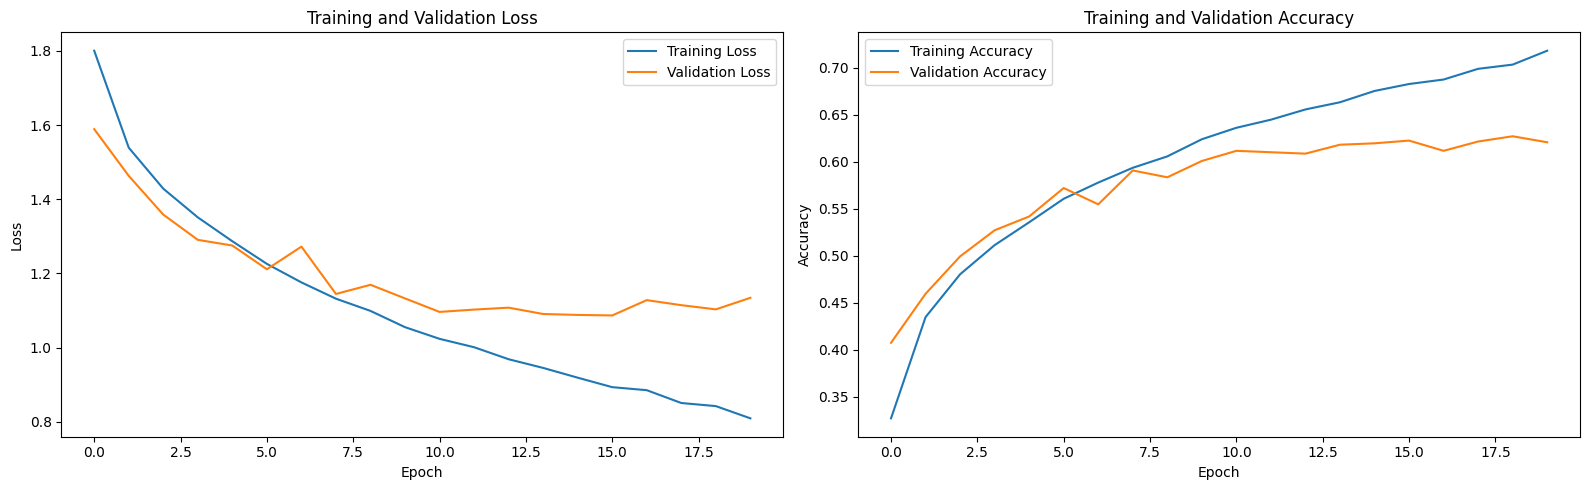

In [30]:
plot_training_curve(best_model_metrices_model4[0], best_model_metrices_model4[1], best_model_metrices_model4[2], best_model_metrices_model4[3])

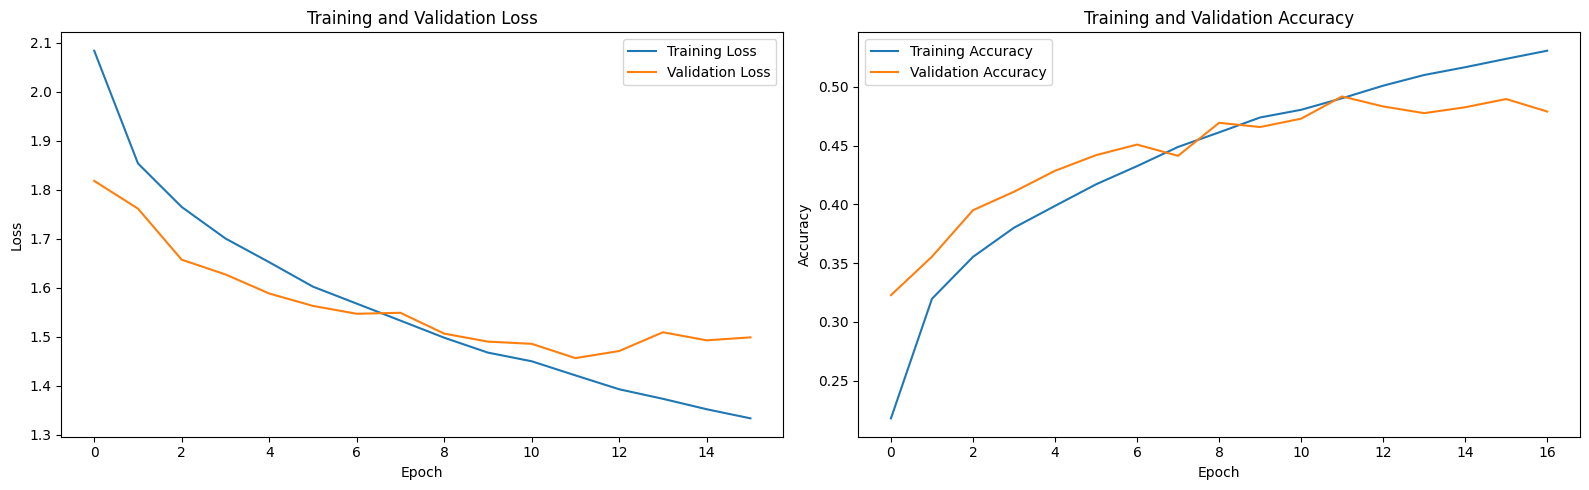

In [31]:
plot_training_curve(best_model_metrices_model5[0], best_model_metrices_model5[1], best_model_metrices_model5[2], best_model_metrices_model5[3])

## Question 2: Comparing without and with k-fold cross validation

### FINDINGS

Observations
* Without Cross validation (CV): The best validation accuracy achieved was 0.6114 in epoch 17.
* With CV: The mean validation accuracy of all folds was  0.62058.
* Hence, the average accuracy of validation sets was observed to be slightly higher in the with CV model compared to the no CV model.

* Cross-validation led to longer training times in the With CV model, as compared to the No CV model. This might be relevant for complex datasets or time sensitive projects. In the current notebook, it will be neglected due to the aim of achieving the best possible model.

* Both models exhibited promising learning curves, indicating effective training.

Result
* Overall, it is concluded that using CV is a good option for the current task as the mean accuracy is slightly better than without CV. By repeatedly training and evaluating the model on different subsets, cross-validation provides a more accurate estimate of the model's true performance and helps in making informed decisions about its effectiveness.
* This can especially useful in the following hyperparameter finetuning.

Theoretical Background
* By training and evaluating the model on different subsets of data, cross-validation provides a more accurate estimate of the model's true performance on unseen data. This leads to better generalization capabilities, as the model learns to capture underlying patterns rather than specific examples.
* With cross-validation, the model is exposed to a variety of training and validation data combinations. This mitigates the impact of any potential data bias present in a single train-test split. The model becomes more robust as it learns to perform well on different data distributions.
* In cases where specific subsets of data contain outliers or anomalies, cross-validation helps mitigate their impact. An outlier in a single train-test split might overly influence the accuracy calculation, while cross-validation averages out such effects.
* Also, CV is useful for hyperparameter tuning which will be the focus of the following code. Cross-validation aids in selecting optimal hyperparameters by repeatedly assessing the model's performance across various parameter combinations. This helps prevent biased hyperparameter choices based on a single train-test split.

### Training the Model without n-fold cross validation

In [42]:
# Creating model
model6 = LeNet_model()

# Same hyperparameters as above

# Training model & returning losses and accuracies for validation and training data
train_losses_model6, val_losses_model6, train_accuracies_model6, val_accuracies_model6, best_val_accuracy_model6, best_epoch_model6, best_model_filename_model6 = train(model6, name_saving_model = "without_n_fold_noaug", loaders = {
    'train': train_loader,
    'validation': val_loader
    }, learning_rate = learning_rate, num_epochs = num_epochs, early_stopping_patience =early_stopping_patience)

Epoch 1
Training Loss: 1.8474152814865112
Validation Loss: 1.6722819326789515
Training Accuracy: 0.308525
Validation Accuracy: 0.3827
-------------------
Epoch 2
Training Loss: 1.5752666996002198
Validation Loss: 1.526959031250826
Training Accuracy: 0.421025
Validation Accuracy: 0.4398
-------------------
Epoch 3
Training Loss: 1.4472533151626588
Validation Loss: 1.3733721493156092
Training Accuracy: 0.470175
Validation Accuracy: 0.4944
-------------------
Epoch 4
Training Loss: 1.3568075813293456
Validation Loss: 1.3749584688502512
Training Accuracy: 0.50835
Validation Accuracy: 0.5058
-------------------
Epoch 5
Training Loss: 1.290048269367218
Validation Loss: 1.2991373854078305
Training Accuracy: 0.533925
Validation Accuracy: 0.5376
-------------------
Epoch 6
Training Loss: 1.2379073396682738
Validation Loss: 1.256509535251909
Training Accuracy: 0.5534
Validation Accuracy: 0.5521
-------------------
Epoch 7
Training Loss: 1.1920611095428466
Validation Loss: 1.25526033617129
Traini

### Summary of Validation Accuracies

In [43]:
print("Best found validation accuracy without cross validation:", best_val_accuracy_model6, "Best epoch:", best_epoch_model6 )
print("Best found mean validation accuracy with cross validation:", mean_accuracy_model2)

Best found validation accuracy without cross validation: 0.6114 Best epoch: 17
Best found mean validation accuracy with cross validation: 0.62058


### Analysis of Training Progress

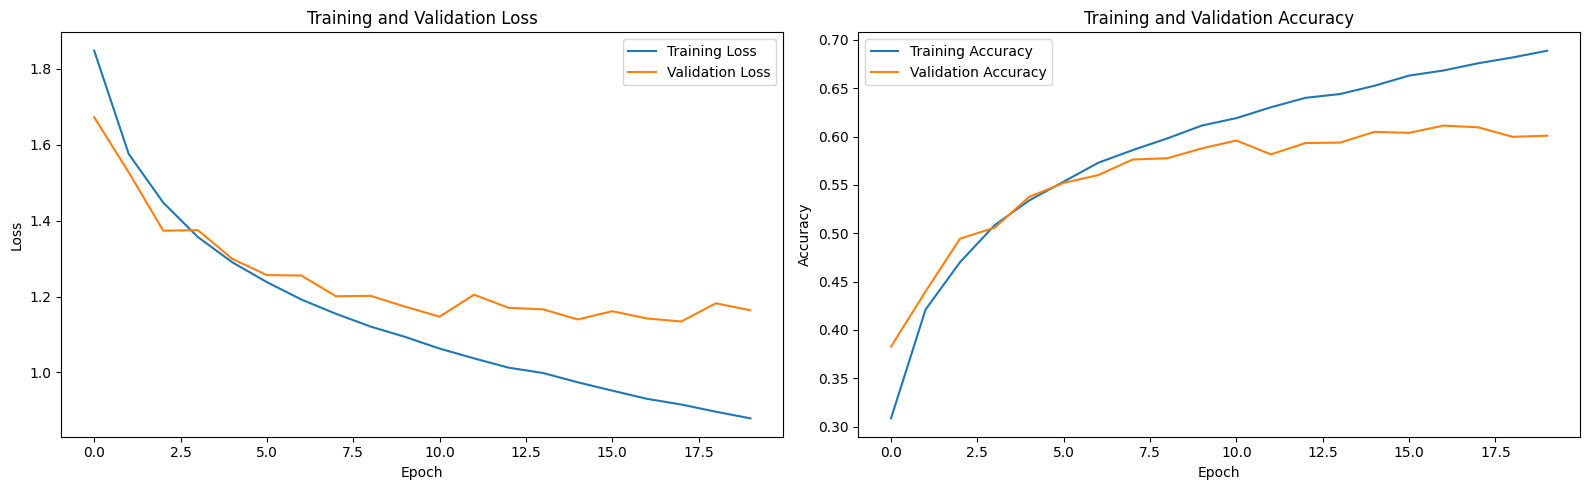

In [44]:
plot_training_curve(train_losses_model6, val_losses_model6, train_accuracies_model6, val_accuracies_model6)

## Question 3: Systematically experimenting with regularization methods

**FINDINGS**

Results
Mean of the best found validation accuracy...
* with no dropout: 0.614 Sd of folds: 0.008770176737101702
* with 0.2 dropout rate: 0.5997600000000001 Sd of folds: 0.01421978902797083
* with 0.8 dropout rate: 0.33482 Sd of folds: 0.030225777078513625
* with 0.1 dropout rate: 0.60992 Sd of folds: 0.009915926583027914
* with 0.1 dropout rate and 0.001 L2 regularization: 0.6021599999999999 Sd of folds: 0.0016304600577751157
* with 0.2 dropout rate and 0.001 L2 regularization: 0.59898 Sd of folds: 0.014866526157781425
* It was also tested to include 2 dropout layers in the model. However, results did not support this. To increase the effect, only 1 droput layer was included.

Learning Curves
* The learning curves show that regularization does prevent overfitting as the learning curves of validaiton and test set are closer to each other. They indicate that the model trains well as it can generalize well on the validation data.
* The learning curves of 0.8 dropout rate illustrate what happens if to much regularization is included. When 80% are dropped out the validation curve behaves very "jumpy" and the validation and training curves are not close to each other.

Conclusion
* Overall, it is concluded that **0.1 dropout rate in combination with 0.001 L2 regularization is the best combination**.

Theoretical Background / Explanation
* The reason why the model is better when regularization is included is:
* Dropout randomly deactivates a fraction of neurons during training, preventing co-adaptation of hidden units and encouraging robustness in learned representations.
* L2 regularization adds a penalty term to the loss function based on the squared magnitudes of model weights, discouraging large weight values and encouraging simpler, more generalized models.
* Both techniques contribute to controlling model complexity and mitigating overfitting, ultimately leading to improved performance on unseen data.

### Training the Models

In [50]:
# Creating model with dropout of 0.2
model_adj1=  LeNet_model_adjusted(0.2)

# Same hyperparameters as before
# New hyperparameters
intensity = "light"


name_saving_model = "model_adj1"

mean_accuracy_modeladj1, std_accuracy_modeladj1, best_model_metrices_modeladj1, best_model_filename_modeladj1  =  train_crossval(model_adj1, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.9048407234191895
Validation Loss: 1.6293962297925524
Training Accuracy: 0.3012
Validation Accuracy: 0.4166
-------------------
Epoch 2
Training Loss: 1.609307123184204
Validation Loss: 1.4826300106230814
Training Accuracy: 0.418475
Validation Accuracy: 0.4667
-------------------
Epoch 3
Training Loss: 1.4900283046722411
Validation Loss: 1.3989675341138414
Training Accuracy: 0.46235
Validation Accuracy: 0.4962
-------------------
Epoch 4
Training Loss: 1.4227640924453735
Validation Loss: 1.3384846798173942
Training Accuracy: 0.483725
Validation Accuracy: 0.5254
-------------------
Epoch 5
Training Loss: 1.3759578636169434
Validation Loss: 1.3098438818743274
Training Accuracy: 0.505575
Validation Accuracy: 0.5341
-------------------
Epoch 6
Training Loss: 1.3318257660865784
Validation Loss: 1.2923694681969418
Training Accuracy: 0.521775
Validation Accuracy: 0.5452
-------------------
Epoch 7
Training Loss: 1.3075496019363404
Validation Loss: 1.2471993778161943
Tr

In [52]:
# Creating model with dropout of 0.1
model_adj2=  LeNet_model_adjusted(0.1)

# Same hyperparameters as before

name_saving_model = "model_adj2"

mean_accuracy_modeladj2, std_accuracy_modeladj2, best_model_metrices_modeladj2, best_model_filename_modeladj2  =  train_crossval(model_adj2, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.8433252182006836
Validation Loss: 1.606082488776772
Training Accuracy: 0.318925
Validation Accuracy: 0.4107
-------------------
Epoch 2
Training Loss: 1.5962100490570068
Validation Loss: 1.493480564682347
Training Accuracy: 0.41775
Validation Accuracy: 0.4572
-------------------
Epoch 3
Training Loss: 1.499538996696472
Validation Loss: 1.412184144281278
Training Accuracy: 0.456125
Validation Accuracy: 0.4902
-------------------
Epoch 4
Training Loss: 1.4328931213378906
Validation Loss: 1.3917764584729626
Training Accuracy: 0.484625
Validation Accuracy: 0.4909
-------------------
Epoch 5
Training Loss: 1.3830264772415162
Validation Loss: 1.3356333204135773
Training Accuracy: 0.500775
Validation Accuracy: 0.5225
-------------------
Epoch 6
Training Loss: 1.338151445388794
Validation Loss: 1.2869984351905288
Training Accuracy: 0.516275
Validation Accuracy: 0.5432
-------------------
Epoch 7
Training Loss: 1.303927224254608
Validation Loss: 1.2626266289668477
Train

In [79]:
# Creating model with dropout of 0.2 nd L2 regularization
model_adj3=  LeNet_model_adjusted(0.2)

L2_reg_rate = 0.001
# Same hyperparameters as before

name_saving_model = "model_adj3"

mean_accuracy_modeladj3, std_accuracy_modeladj3, best_model_metrices_modeladj3, best_model_filename_modeladj3  =  train_crossval(model_adj3, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.8450378395080567
Validation Loss: 1.6046011645323153
Training Accuracy: 0.313375
Validation Accuracy: 0.4114
-------------------
Epoch 2
Training Loss: 1.565890482711792
Validation Loss: 1.4491679235628456
Training Accuracy: 0.426575
Validation Accuracy: 0.4638
-------------------
Epoch 3
Training Loss: 1.472023642730713
Validation Loss: 1.3681794275903398
Training Accuracy: 0.4629
Validation Accuracy: 0.5064
-------------------
Epoch 4
Training Loss: 1.4137491271972655
Validation Loss: 1.3229554322115176
Training Accuracy: 0.4875
Validation Accuracy: 0.527
-------------------
Epoch 5
Training Loss: 1.3584927320480347
Validation Loss: 1.2749766339162352
Training Accuracy: 0.51005
Validation Accuracy: 0.5449
-------------------
Epoch 6
Training Loss: 1.3252020714759827
Validation Loss: 1.2620997937621585
Training Accuracy: 0.524575
Validation Accuracy: 0.5545
-------------------
Epoch 7
Training Loss: 1.2894931135177612
Validation Loss: 1.2410542573898462
Traini

In [70]:
# Creating model with dropout of 0.2 and L2 regularization
L2_reg_rate = 0.001

model_adj4=  LeNet_model_adjusted(0.1)

# Same hyperparameters as before

name_saving_model = "model_adj4"

mean_accuracy_modeladj4, std_accuracy_modeladj4, best_model_metrices_modeladj4, best_model_filename_modeladj4  =  train_crossval(model_adj4, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.9256961391448975
Validation Loss: 1.7009988134833658
Training Accuracy: 0.2806
Validation Accuracy: 0.3746
-------------------
Epoch 2
Training Loss: 1.6611725959777832
Validation Loss: 1.5824523632693444
Training Accuracy: 0.39455
Validation Accuracy: 0.4257
-------------------
Epoch 3
Training Loss: 1.551720189666748
Validation Loss: 1.4707089032337164
Training Accuracy: 0.435125
Validation Accuracy: 0.4623
-------------------
Epoch 4
Training Loss: 1.4770683935165405
Validation Loss: 1.4360812925229407
Training Accuracy: 0.4664
Validation Accuracy: 0.483
-------------------
Epoch 5
Training Loss: 1.4128053365707398
Validation Loss: 1.363832763805511
Training Accuracy: 0.494275
Validation Accuracy: 0.5142
-------------------
Epoch 6
Training Loss: 1.3630868718147278
Validation Loss: 1.3245099236251443
Training Accuracy: 0.510525
Validation Accuracy: 0.5352
-------------------
Epoch 7
Training Loss: 1.3228073336601258
Validation Loss: 1.3186384917824132
Traini

In [68]:
# Creating model with dropout of 0.8
model_adj5=  LeNet_model_adjusted(0.8)

L2_reg_rate = 0
# Same hyperparameters as before

name_saving_model = "model_adj5"

mean_accuracy_modeladj5, std_accuracy_modeladj5, best_model_metrices_modeladj5, best_model_filename_modeladj5  =  train_crossval(model_adj5, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 2.154139227294922
Validation Loss: 2.0747472381895515
Training Accuracy: 0.188475
Validation Accuracy: 0.2611
-------------------
Epoch 2
Training Loss: 2.054528804016113
Validation Loss: 2.0767657346786206
Training Accuracy: 0.2331
Validation Accuracy: 0.2332
-------------------
Epoch 3
Training Loss: 1.9829156549453735
Validation Loss: 2.003661533070218
Training Accuracy: 0.260775
Validation Accuracy: 0.2924
-------------------
Epoch 4
Training Loss: 1.917441704940796
Validation Loss: 1.95615602982272
Training Accuracy: 0.2885
Validation Accuracy: 0.3306
-------------------
Epoch 5
Training Loss: 1.8628779949188232
Validation Loss: 1.9228231512057554
Training Accuracy: 0.3084
Validation Accuracy: 0.3364
-------------------
Epoch 6
Training Loss: 1.8354224138259887
Validation Loss: 1.8615884461979957
Training Accuracy: 0.3204
Validation Accuracy: 0.3671
-------------------
Epoch 7
Training Loss: 1.8069037731170654
Validation Loss: 1.8895136793707585
Training Acc

### Summary of Mean Fold Validation Accuracy & Standard Deviation

In [81]:
print("Mean of the best found validation accuracy...")
print("with no dropout:", mean_accuracy_model1, "Sd of folds:", std_accuracy_model1)
print("with 0.2 dropout rate:", mean_accuracy_modeladj1, "Sd of folds:", std_accuracy_modeladj1)
print("with 0.8 dropout rate:", mean_accuracy_modeladj5, "Sd of folds:", std_accuracy_modeladj5)
print("with 0.1 dropout rate:", mean_accuracy_modeladj2, "Sd of folds:", std_accuracy_modeladj2)
print("with 0.1 dropout rate and 0.001 L2 regularization:", mean_accuracy_modeladj4, "Sd of folds:", std_accuracy_modeladj4)
print("with 0.2 dropout rate and 0.001 L2 regularization:", mean_accuracy_modeladj3, "Sd of folds:", std_accuracy_modeladj3)

Mean of the best found validation accuracy...
with no dropout: 0.614 Sd of folds: 0.008770176737101702
with 0.2 dropout rate: 0.5997600000000001 Sd of folds: 0.01421978902797083
with 0.8 dropout rate: 0.33482 Sd of folds: 0.030225777078513625
with 0.1 dropout rate: 0.60992 Sd of folds: 0.009915926583027914
with 0.1 dropout rate and 0.001 L2 regularization: 0.6021599999999999 Sd of folds: 0.0016304600577751157
with 0.2 dropout rate and 0.001 L2 regularization: 0.59898 Sd of folds: 0.014866526157781425


### Analysis of Training Progress (of promising models)

No Droput


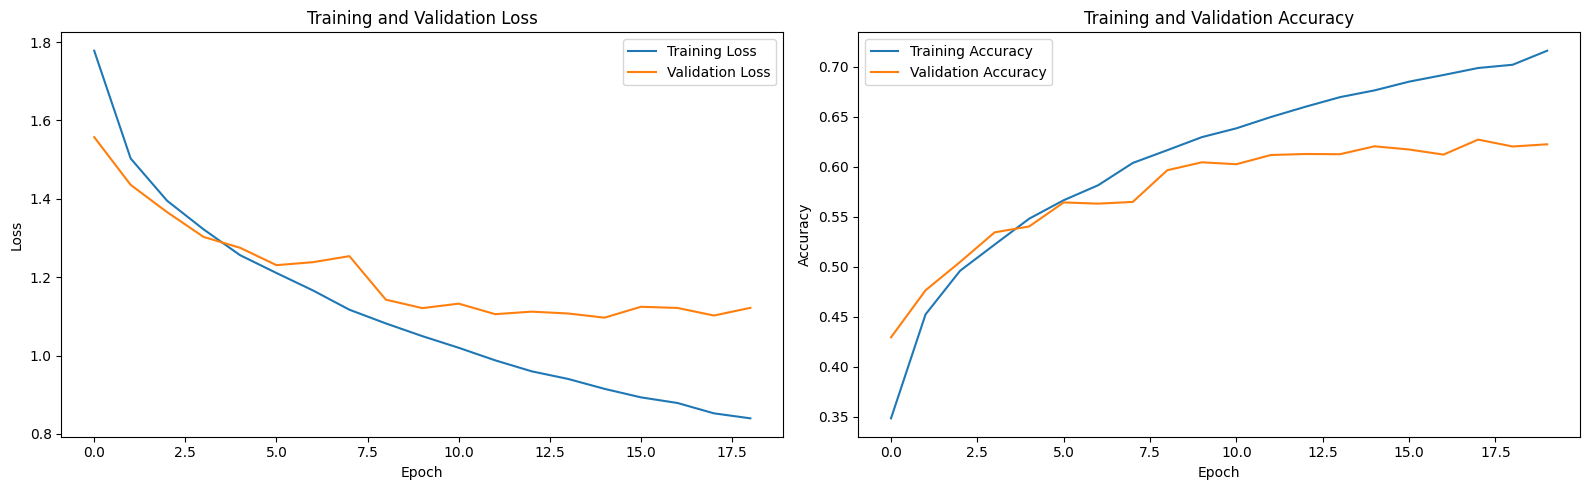

In [73]:
print("No Droput")
plot_training_curve(best_model_metrices_model1[0], best_model_metrices_model1[1], best_model_metrices_model1[2], best_model_metrices_model1[3])

with 0.2 dropout rate


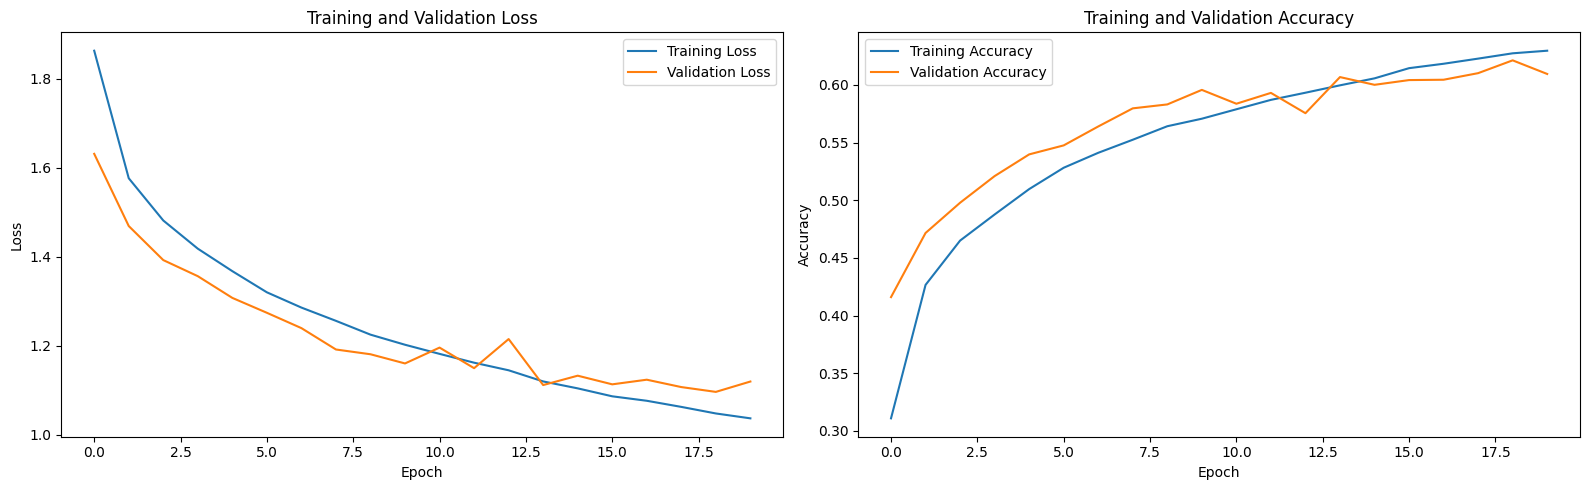

In [74]:
print("with 0.2 dropout rate")
plot_training_curve(best_model_metrices_modeladj1[0], best_model_metrices_modeladj1[1], best_model_metrices_modeladj1[2], best_model_metrices_modeladj1[3])

with 0.1 dropout rate


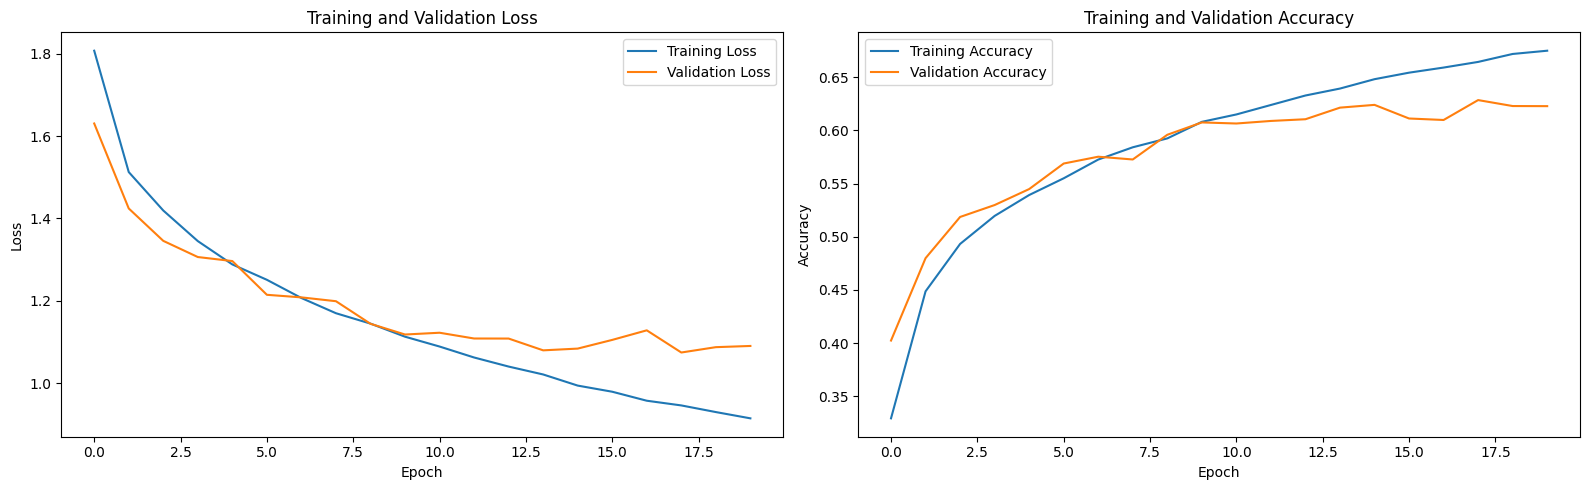

In [77]:
print("with 0.1 dropout rate")
plot_training_curve(best_model_metrices_modeladj2[0], best_model_metrices_modeladj2[1], best_model_metrices_modeladj2[2], best_model_metrices_modeladj2[3])

with 0.2 dropout rate and 0.001 L2 regularization


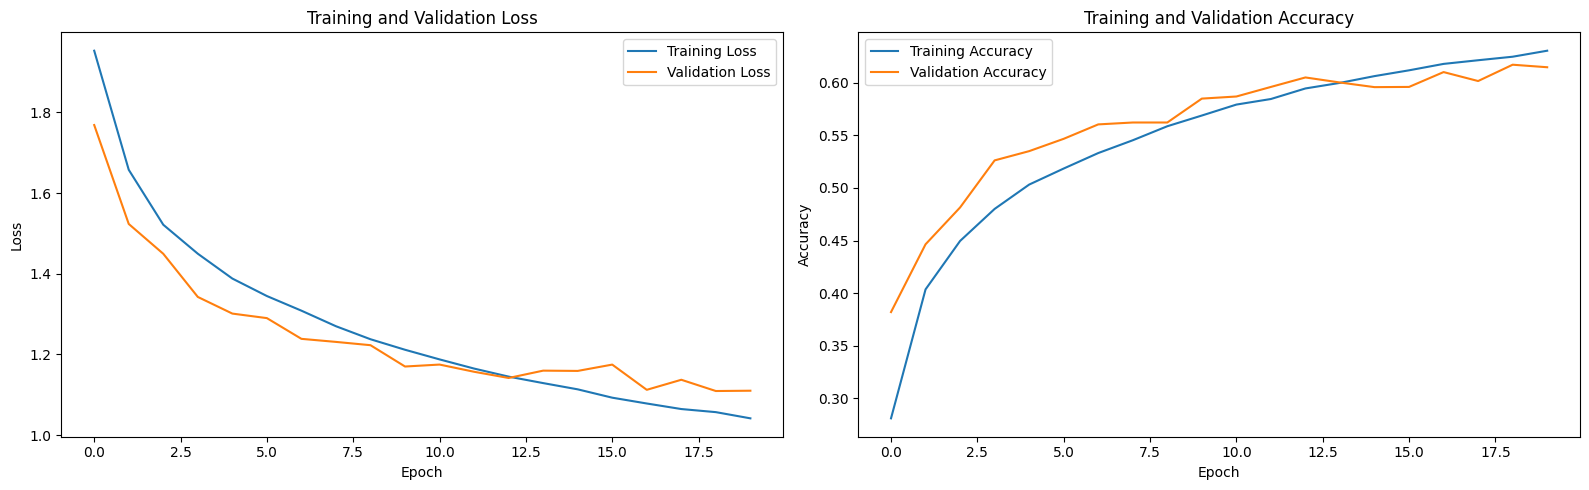

In [82]:
print("with 0.2 dropout rate and 0.001 L2 regularization")
plot_training_curve(best_model_metrices_modeladj3[0], best_model_metrices_modeladj3[1], best_model_metrices_modeladj3[2], best_model_metrices_modeladj3[3])

with 0.1 dropout rate and 0.001 L2 regularization


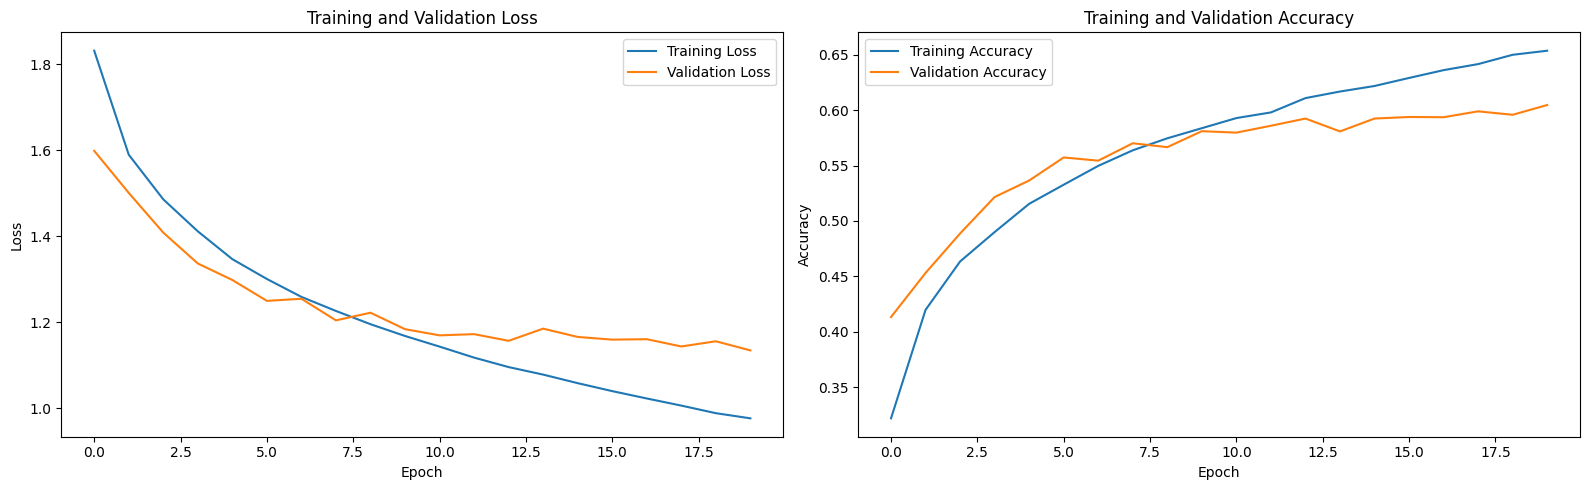

In [76]:
print("with 0.1 dropout rate and 0.001 L2 regularization")
plot_training_curve(best_model_metrices_modeladj4[0], best_model_metrices_modeladj4[1], best_model_metrices_modeladj4[2], best_model_metrices_modeladj4[3])

with 0.8 dropout rate


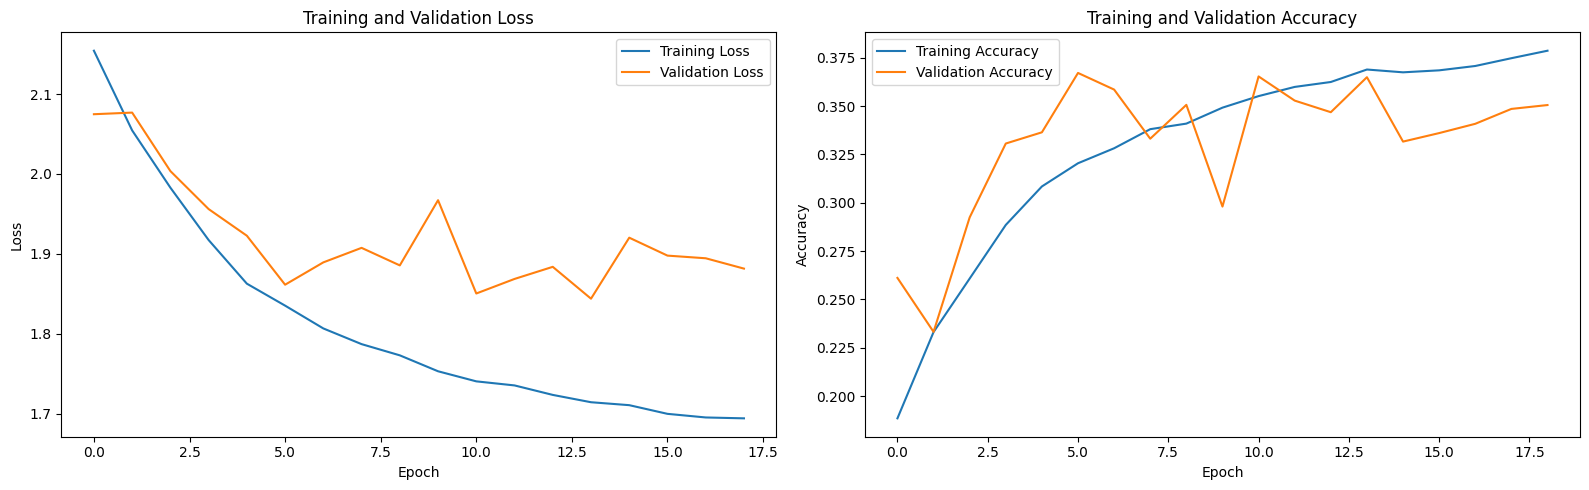

In [75]:
print("with 0.8 dropout rate")
plot_training_curve(best_model_metrices_modeladj5[0], best_model_metrices_modeladj5[1], best_model_metrices_modeladj5[2], best_model_metrices_modeladj5[3])

## Question 4-5: Training & Analysis of the final model

**FINDINGS**

1. **Recapitulate: Are there classes that are difficult to classify correctly? Is this still the case with augmentation?**
* Yes. From the confusion matrix and plots of the incorrectly classfied images it can be seen that images belonging to the category "transportation" are more often misclassified with other images of the same category. The same holds for the second catgeroy "animals".
* Airplan, ship and truck often are often falsy predicted as one of the others: Automobile often missclassified as truck (140 times) and other way around (134). Ship often misclassified as airplane (208 times) but not the other way around (47)
* In the confusion matrix the highlighted "square" shows nicely the animal classes. 'bird', 'cat', 'deer', 'dog', 'frog', 'horse' are often misclassified. Worst is "bird" and "deer".

2. **Can you identify particular images that fail to classify consistently? Speculate: why?**
* Some of the images might be prone to misclassification due to the similarity of another class. For example, "deer" and "dog" might be very closely related and "truck" and "automobile" making it much harder for a model to identify the very small differences of patterns in those pairs.
* In addition, automobiles are more often than other transportations misclassified as an animal. Maybe that is due to the lights that look like eyes and the front of the car that looks like a head of an animal.

### Training the Final Model

In [83]:
# Creating model with dropout of 0.1
model_final1=  LeNet_model_adjusted(0.1)
name_saving_model = "model_final1"

# Hyperparameters
L2_reg_rate = 0.001
intensity = "light"


learning_rate= 0.001
num_epochs= 50
early_stopping_patience=5
val_transform = val_test_transform
train_transform_funct = train_transform_funct
batch_size = 64
k = 5


mean_accuracy_modelfinal1, std_accuracy_modelfinal1, best_model_metrices_modelfinal1, best_model_filename_modelfinal1  =  train_crossval(model_final1, trainvalset, train_transform_funct = train_transform_funct, intensity = intensity, val_transform = val_test_transform,
                                                                                                                                                            k=k, learning_rate=learning_rate, num_epochs= num_epochs, batch_size = batch_size, early_stopping_patience=early_stopping_patience,
                                                                                                                                                            L2_reg_rate=L2_reg_rate, name_saving_model =name_saving_model)

Epoch 1
Training Loss: 1.8746442911148071
Validation Loss: 1.6517691392048148
Training Accuracy: 0.310275
Validation Accuracy: 0.4035
-------------------
Epoch 2
Training Loss: 1.5675570852279663
Validation Loss: 1.4560589964982051
Training Accuracy: 0.433
Validation Accuracy: 0.4671
-------------------
Epoch 3
Training Loss: 1.4503857288360595
Validation Loss: 1.3649952897600308
Training Accuracy: 0.475
Validation Accuracy: 0.513
-------------------
Epoch 4
Training Loss: 1.374367011642456
Validation Loss: 1.3196296236317628
Training Accuracy: 0.5058
Validation Accuracy: 0.5215
-------------------
Epoch 5
Training Loss: 1.31140727186203
Validation Loss: 1.275207861973222
Training Accuracy: 0.5278
Validation Accuracy: 0.5429
-------------------
Epoch 6
Training Loss: 1.2626139485359191
Validation Loss: 1.2690687308645552
Training Accuracy: 0.546925
Validation Accuracy: 0.5509
-------------------
Epoch 7
Training Loss: 1.236794514465332
Validation Loss: 1.26827007494155
Training Accurac

### Analysing the Training Process

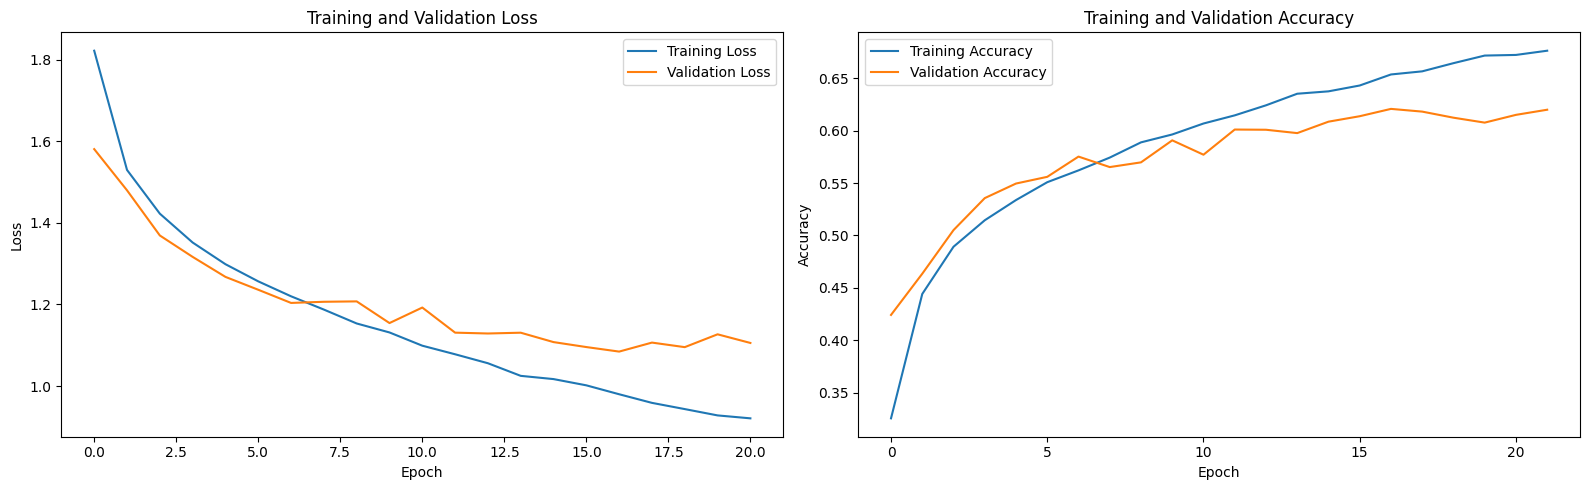

In [139]:
plot_training_curve(best_model_metrices_modelfinal1[0], best_model_metrices_modelfinal1[1], best_model_metrices_modelfinal1[2], best_model_metrices_modelfinal1[3])

**FINDING** The Training curves look promising. There might be small overfitting as the validaiton loss is higher than the trianing loss after epoch 10. However, all in all it concluded as a moderate model. Further hypertuning, grid search or more complex model architectures could improve the performance.

### Analysing the Final Model

**Confusion Matrix and test accuracy**

Test accuracy: 0.590


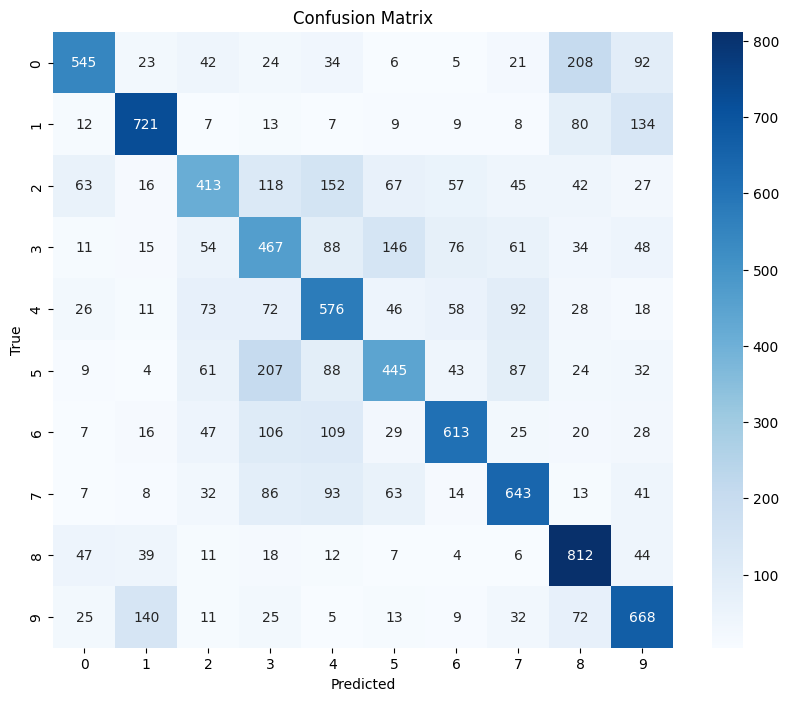

0.5903

In [140]:
# test accuracy and matrix
# Call the function to get the accuracy on test set and confusion matrix
saved_nn_final1= LeNet_model_adjusted(0.1)
saved_nn_final1.load_state_dict(torch.load(best_model_filename_modelfinal1))

# Evaluate the model and show the confusion matrix
evaluate_confusion_matrix(saved_nn_final1, test_loader, label_nr = 10)

# label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**Histogram of predictions**

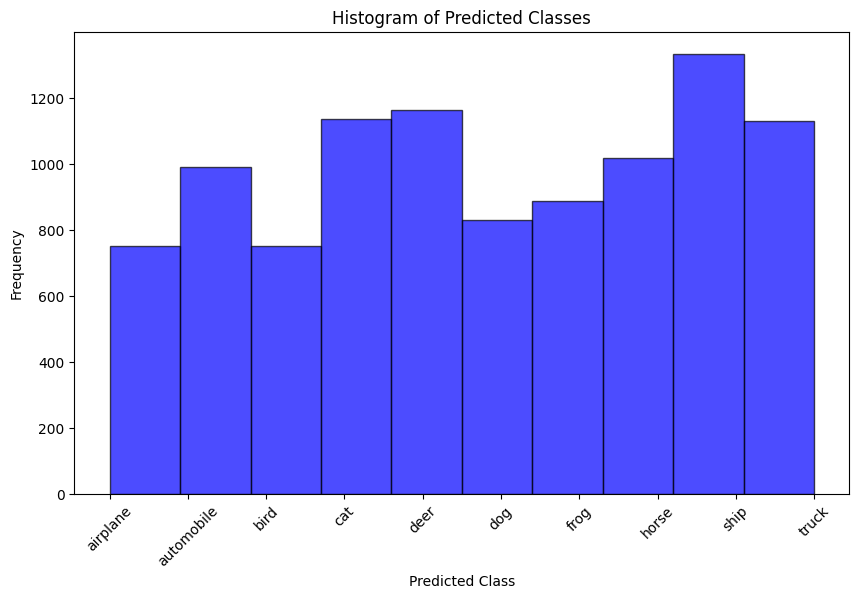

In [121]:
# Plot histogram of predictions for the classes
plot_predictions_histogram(saved_nn_final1, test_loader)

**Correct versus incorrect images**

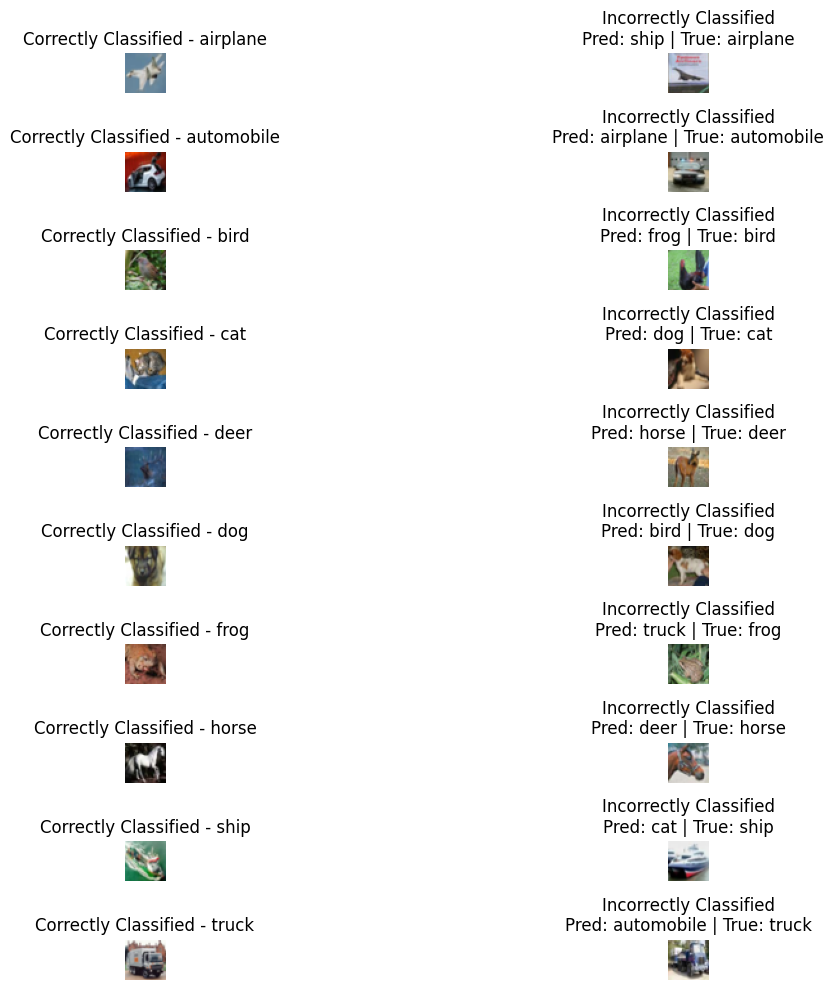

In [125]:
# Display correctly and incorrectly classified images
plot_correct_vs_incorrect_images(saved_nn_final1, test_loader, image_size=(16, 10))